In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import numpy as np

# Read the CSV file
data = pd.read_csv('simulation_results.csv')

# Define the columns to group by (first 7 columns)
group_by_columns = [
    'Fitness Function', 'Constraint', 'Constraint Handling Method', 
    'Particle Inertia', 'Personal Confidence', 'Swarm Confidence', 
    'Population Size', 'Particle Speed Limit'
]

# Define the columns to average over (last 3 columns)
average_columns = ['Final Fitness', 'Optimum Found After', 'Iterations']

# Group the data by the specified columns and calculate the mean of the remaining columns
grouped_data = data.groupby(group_by_columns, as_index=False)[average_columns].mean()

grouped_data['Environment'] = grouped_data['Fitness Function'] + ", " + grouped_data['Constraint'] + ", " + grouped_data['Constraint Handling Method']
grouped_data['Environment'] = grouped_data['Environment'].str.replace(r', Constraint 1, Penalty Method', ', without Const', regex=True)
grouped_data['Environment'] = grouped_data['Environment'].str.replace(r'Constraint ', 'Const', regex=True)
grouped_data['Environment'] = grouped_data['Environment'].str.replace(r' Method', '', regex=True)

# Save the grouped and averaged data to a new CSV file
grouped_data.to_csv('jonas_averaged_results.csv', index=False)

print("Averaged results saved to averaged_results.csv")

Averaged results saved to averaged_results.csv


In [9]:
def scatter_plot_with_labels(data, x_group_cols, y_col, filter_col=None, filter_value=None, alpha=0.1, point_color='blue', title=None):
    """
    Create a scatter plot with labeled X-axis ticks and optional filtering.
    
    Parameters:
        data (pd.DataFrame): The input dataset.
        x_col (str): The column name for the X-axis.
        y_col (str): The column name for the Y-axis.
        filter_col (str, optional): The column to filter on.
        filter_value (any, optional): The value to exclude from the filter_col.
        alpha (float, optional): Transparency of scatter points. Defaults to 0.1.
        point_color (str, optional): Color of the scatter points. Defaults to 'blue'.
        title (str, optional): Title of the plot. Defaults to None.
    """
    # Filter data if filtering is specified
    if filter_col and filter_value is not None:
        filtered_data = data[data[filter_col] != filter_value]
    else:
        filtered_data = data
    
    # Handle single or multiple X-axis columns
    filtered_data['x_group'] = filtered_data[x_group_cols].astype(str).agg(', '.join, axis=1)
    
    # Get unique groups and map them to integer positions on the X-axis
    unique_groups = filtered_data['x_group'].unique()
    group_positions = {group: i for i, group in enumerate(unique_groups)}
    filtered_data['x_position'] = filtered_data['x_group'].map(group_positions)
    
    # Plot the scatter plot
    plt.figure(figsize=(10, 5))
    plt.scatter(
        filtered_data['x_position'], 
        filtered_data[y_col], 
        alpha=alpha, 
        label=y_col
    )
    plt.xticks(
        ticks=list(group_positions.values()), 
        labels=list(group_positions.keys()), 
        rotation=45, 
        ha='right'
    )
    plt.xlabel('Groups (Personal Confidence, Swarm Confidence)')
    plt.ylabel(y_col)
    plt.title(title or f'Grouped Scatter Plot: {y_col} by {", ".join(x_group_cols)}')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

def scatter_plot_with_labels_colored(data, x_group_cols, y_col, filter_col=None, filter_value=None, alpha=0.1, title=None):
    """
    Create a scatter plot with labeled X-axis ticks and optional filtering.

    Parameters:
        data (pd.DataFrame): The input dataset.
        x_group_cols (list of str): List of column names to group and label on the X-axis.
        y_col (str): The column name for the Y-axis.
        filter_col (str, optional): The column to filter on.
        filter_value (any, optional): The value to exclude from the filter_col.
        alpha (float, optional): Transparency of scatter points. Defaults to 0.1.
        title (str, optional): Title of the plot. Defaults to None.
    """
    # Filter data if filtering is specified
    if filter_col and filter_value is not None:
        filtered_data = data[data[filter_col] != filter_value].copy()
    else:
        filtered_data = data.copy()

    # Generate a new column for X-axis group labels
    filtered_data['x_group'] = filtered_data[x_group_cols].astype(str).agg(', '.join, axis=1)

    # Extract unique X-axis values for labeling
    x_values = filtered_data['x_group'].apply(lambda x: x.split(', ', 1)[1] if ',' in x else x)

    # Define a color map for categorical values in 'Fitness Function'
    fitness_functions = sorted(filtered_data['Fitness Function'].unique())  # Get unique categories
    colors = ['red', 'blue', 'green']  # Assign a color to each category, adjust as needed

    # Create a mapping of Fitness Function to color
    fitness_color_map = dict(zip(fitness_functions, colors))

    # Map the 'Fitness Function' column to its respective color
    filtered_data['Color'] = filtered_data['Fitness Function'].map(fitness_color_map)

    # Normalize Population size to adjust the size of the dots
    if filter_col is not None:
        population_sizes = filtered_data[filter_col]
        size_scale = 100  # Scale factor to control the size of points
        normalized_sizes = np.clip(population_sizes / population_sizes.max() * size_scale, 10, 100)
    else:
        normalized_sizes = 50  # Default size if no filter_col is provided

    # Plot the scatter plot
    plt.figure(figsize=(10, 5))
    plt.scatter(
        filtered_data['x_group'], 
        filtered_data[y_col], 
        c=filtered_data['Color'],  # Use the mapped colors
        s=normalized_sizes,  # Map population size to dot size
        alpha=alpha
    )

    # Add title and labels
    plt.title(title or f'{", ".join(x_group_cols)} vs. {y_col}')
    plt.xlabel('X-axis Groups')
    plt.ylabel(y_col)

    # Set x-ticks and labels
    plt.xticks(
        ticks=range(len(x_values)), 
        labels=x_values, 
        rotation=90
    )

    # Add grid
    plt.grid(alpha=0.3)

    # Create legend handles based on the color map
    legend_handles = [mpatches.Patch(color=color, label=fitness_function) 
                      for fitness_function, color in fitness_color_map.items()]
    plt.legend(handles=legend_handles, title='Fitness Function')

    # Show plot
    plt.tight_layout()
    plt.show()

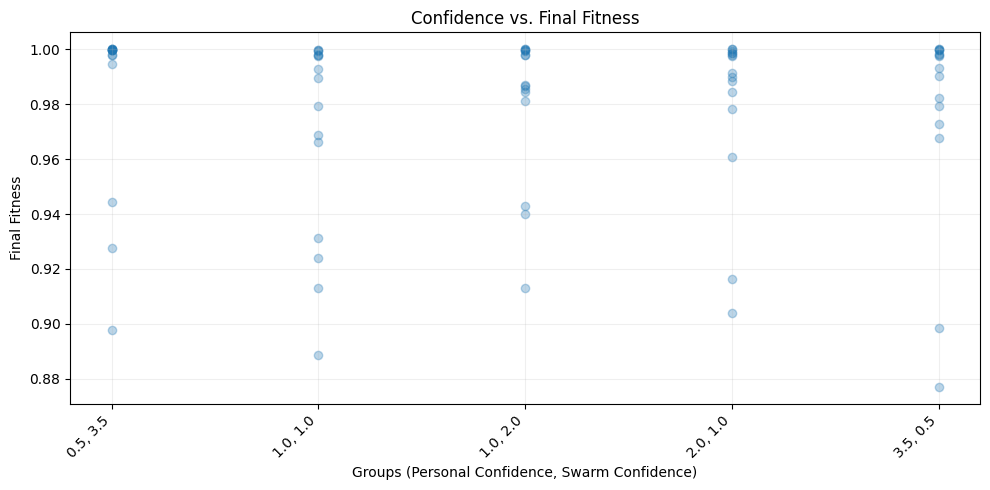

In [5]:
data = pd.read_csv('simulation_results.csv')

scatter_plot_with_labels(
    data=grouped_data,
    x_group_cols=['Personal Confidence', 'Swarm Confidence'], 
    y_col='Final Fitness', 
    filter_col='Personal Confidence', 
    filter_value=13, 
    alpha=0.3, 
    point_color='blue', 
    title='Confidence vs. Final Fitness'
)

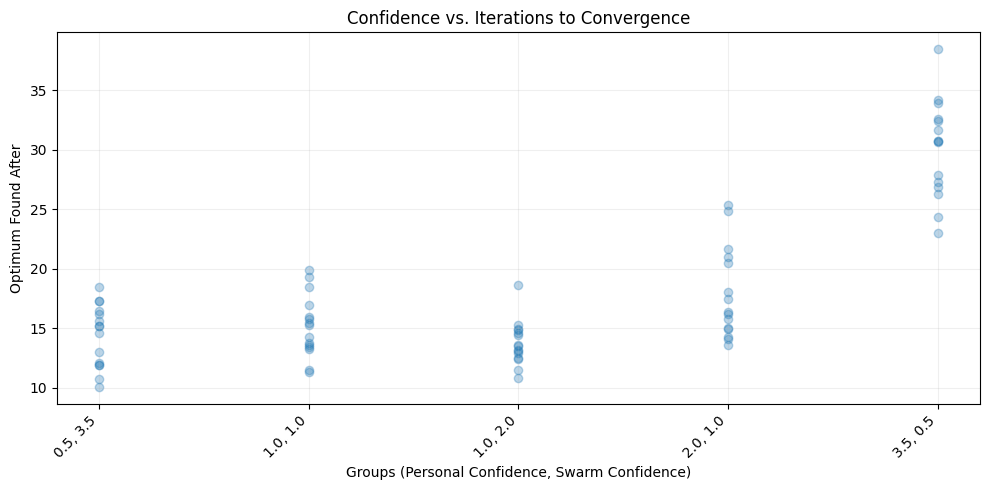

In [24]:
scatter_plot_with_labels(
    data=grouped_data,
    x_group_cols=['Personal Confidence', 'Swarm Confidence'], 
    y_col='Optimum Found After', 
    filter_col='Personal Confidence', 
    filter_value=13, 
    alpha=0.3, 
    point_color='orange', 
    title='Confidence vs. Iterations to Convergence'
)

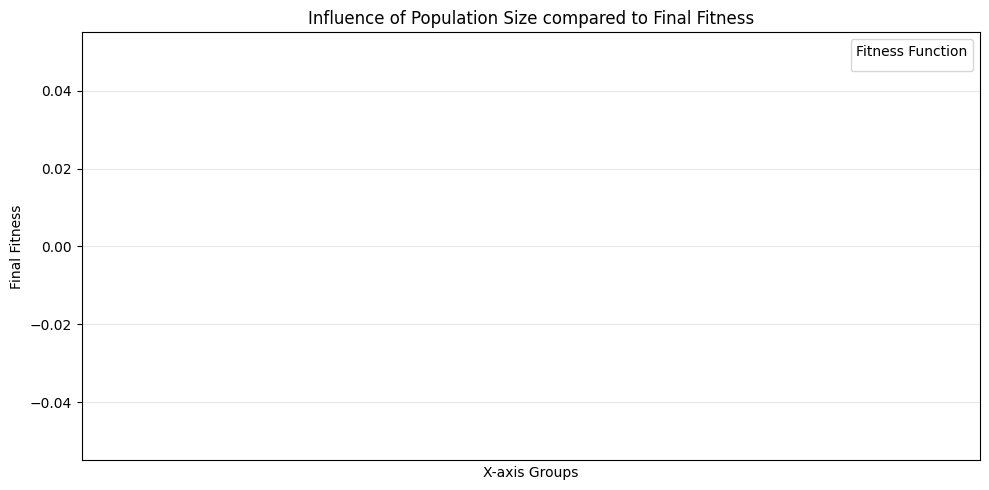

In [10]:
scatter_plot_with_labels_colored(
    data=grouped_data,
    x_group_cols=['Environment'],
    y_col='Final Fitness', 
    filter_col='Population Size', 
    filter_value=13, 
    alpha=0.5,
    title="Influence of Population Size compared to Final Fitness"
)

In [11]:
def scatter_plot_with_labels_colored(data, x_col, y_col, filter_col=None, filter_value=None, alpha=0.1, title=None):
    """
    Create a scatter plot with labeled X-axis ticks and optional filtering.
    
    Parameters:
        data (pd.DataFrame): The input dataset.
        x_col (str): The column name for the X-axis.
        y_col (str): The column name for the Y-axis.
        filter_col (str, optional): The column to filter on.
        filter_value (any, optional): The value to exclude from the filter_col.
        alpha (float, optional): Transparency of scatter points. Defaults to 0.1.
        title (str, optional): Title of the plot. Defaults to None.
    """
    # Filter data if filtering is specified
    if filter_col and filter_value is not None:
        filtered_data = copy.copy(data[data[filter_col] != filter_value])
    else:
        filtered_data = copy.copy(data)
    
    # Extract unique X-axis values for labeling (removes everything before the first comma in the 'Environment' column)
    x_values = filtered_data[x_col].apply(lambda x: x.split(', ', 1)[1] if ',' in x else x)

    # Define a color map for categorical values in 'Fitness Function'
    fitness_functions = sorted(filtered_data['Fitness Function'].unique())  # Get unique categories
    colors = ['red', 'blue', 'green']  # Assign a color to each category, adjust as needed

    # Create a mapping of Fitness Function to color
    fitness_color_map = dict(zip(fitness_functions, colors))

    # Map the 'Fitness Function' column to its respective color
    filtered_data['Color'] = filtered_data['Fitness Function'].map(fitness_color_map)

    # Normalize Population size to adjust the size of the dots
    population_sizes = filtered_data[filter_col]
    size_scale = 100  # Scale factor to control the size of points
    normalized_sizes = np.clip(population_sizes / population_sizes.max() * size_scale, 10, 100)  # Adjust to a reasonable range

    # Plot the scatter plot
    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(
        filtered_data[x_col], 
        filtered_data[y_col], 
        c=filtered_data['Color'],  # Use the mapped colors
        s=normalized_sizes,  # Map population size to dot size
        alpha=alpha
    )

    # Add title and labels
    plt.title(title or f'{x_col} vs. {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)

    # Set x-ticks
    plt.xticks(ticks=filtered_data['Environment'], labels=x_values, rotation=90)

    # Add grid
    plt.grid(alpha=0.1)

    # Create legend handles based on the color map
    legend_handles = [mpatches.Patch(color=color, label=fitness_function) 
                    for fitness_function, color in fitness_color_map.items()]

    plt.legend(handles=legend_handles, title='Fitness Function')

    # Show plot
    plt.show()

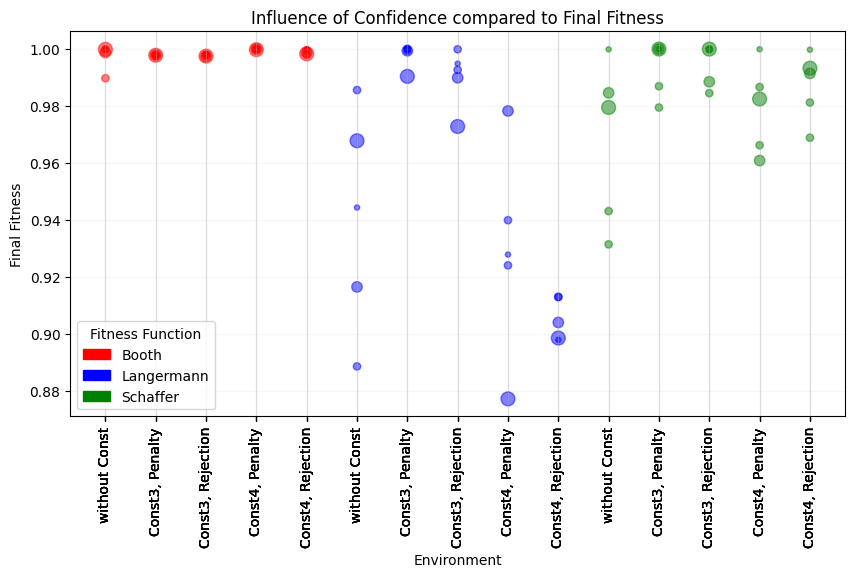

In [23]:
grouped_data = pd.read_csv("./jonas_averaged_results.csv")

scatter_plot_with_labels_colored(
    data=grouped_data,
    x_col='Environment', 
    y_col='Final Fitness', 
    filter_col='Personal Confidence', 
    filter_value=13, 
    alpha=0.5,
    title="Influence of Confidence compared to Final Fitness"
)

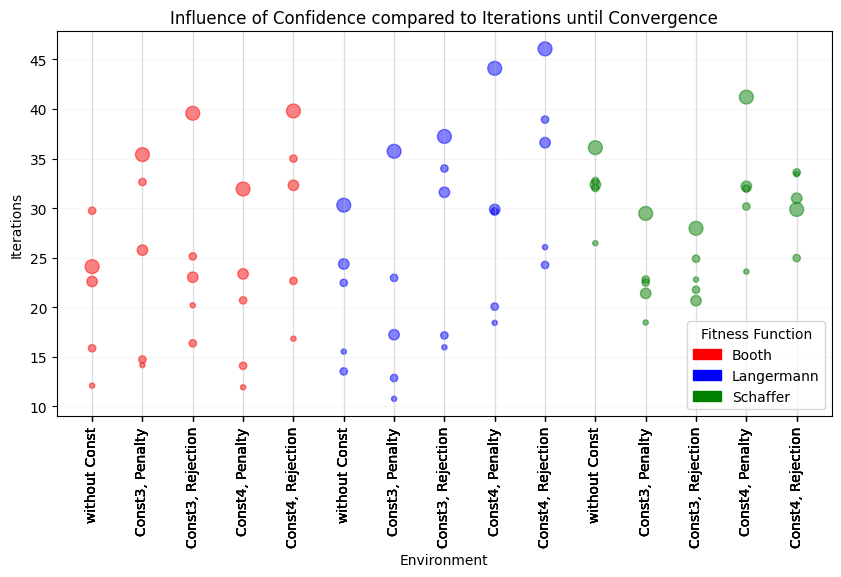

In [22]:
scatter_plot_with_labels_colored(
    data=grouped_data,
    x_col='Environment', 
    y_col='Iterations', 
    filter_col='Personal Confidence', 
    filter_value=13, 
    alpha=0.5,
    title="Influence of Confidence compared to Iterations until Convergence"
)